Notebook for training (finetuning) image-to-LaTeX models. Training was done on Google Colab.

# Imports and Installations

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CSE 493G1 Text to Latex'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/Shared drives/{}'.format(FOLDERNAME))

%cd '/content/drive/Shared drives/CSE 493G1 Text to Latex /'

Mounted at /content/drive
/content/drive/Shared drives/CSE 493G1 Text to Latex 


In [ ]:
# pip installs
!pip install -q datasets jiwer
!pip install -q evaluate
!pip install -q transformers[torch]
!pip install -q accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
# imports
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import h5py
from PIL import Image

from tqdm.notebook import tqdm

from datasets import load_metric

USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


# New Data Processing

Extract the data from the handwritten dataset H5 file into dicts:

In [ ]:
splits = ("train", "val", "test")
dataset = {t: dict() for t in splits}
handwritten_filename = "data/handwritten_dataset.h5"
with h5py.File(handwritten_filename, "r") as f:
    for dataset_type in splits:
        dataset_split = dataset[dataset_type]
        split_group = f[dataset_type]
        for attr in ("N", "max_height", "max_width", "max_tokens", "shape_orderings"):
            dataset_split[attr] = split_group.attrs[attr]

        dataset_split["shape_to_counts"] = dict()
        dataset_split["shape_to_imgs"] = dict()
        dataset_split["shape_to_img_nums"] = dict()
        dataset_split["shape_to_formula_idxs"] = dict()
        dataset_split["shape_to_token_nums"] = dict()

        for shape_name in split_group.keys():
            shape_group = split_group[shape_name]
            shape = tuple(int(i) for i in shape_name.split("x"))
            dataset_split["shape_to_counts"][shape] = shape_group.attrs["count"]

            dtypes = {"imgs": torch.uint8, "img_nums": torch.int32, "formula_idxs": torch.int32, "token_nums": torch.int16}

            for info_name in dtypes.keys():
                info_dataset = shape_group[info_name][()]
                dataset_split[f"shape_to_{info_name}"][shape] \
                  = torch.tensor(info_dataset, dtype=dtypes[info_name])


Extract the mappings of word to token number and vice-versa:

In [ ]:
vocab_file = "data/vocab_to_idx.txt"
with open(vocab_file, "r") as f:
    word_and_idx = [l.split(" ") for l in f.read().split("\n")]
    word_to_idx = {wi[0]: int(wi[1]) for wi in word_and_idx}
    idx_to_word = {int(wi[1]): wi[0] for wi in word_and_idx}
    idx_to_word[-100] = '<pad>'

Get a random training example's image and tokens to see if they match:

In [ ]:
def get_example(dataset_split, example_num, minimal=False):
    remaining = example_num
    for shape_np in dataset_split["shape_orderings"]:
        shape = tuple(shape_np)
        shape_count = dataset_split["shape_to_counts"][shape]
        if remaining - shape_count < 0:
            break
        remaining -= shape_count

    if minimal:
        return {
            "img": dataset_split["shape_to_imgs"][shape][remaining],
            "token_nums": token_nums.long(),
        }

    token_nums = dataset_split["shape_to_token_nums"][shape][remaining]
    tokens = [idx_to_word[token_num.item()] for token_num in token_nums]

    return {
        "img": dataset_split["shape_to_imgs"][shape][remaining],
        "img_num": dataset_split["shape_to_img_nums"][shape][remaining],
        "formula_idx": dataset_split["shape_to_formula_idxs"][shape][remaining],
        "token_nums": token_nums.long(),
        "tokens": tokens
    }

63517 ['<s>', 'G', '_', '{', 'r', '}', '^', '{', '(', '2', ')', '}', '=', 'x', '^', '{', '\\frac', '{', 'r', '-', '1', '}', '{', '2', '}', '}', '\\cdot', '\\prod', '_', '{', 'm', '=', '1', '}', '^', '{', '\\nu', '-', 'r', '}', '\\left(', '\\frac', '{', 'U', '_', '{', 'm', '}', '^', '{', '2', '}', '}', '{', 'U', '_', '{', 'm', '}', '^', '{', '2', '}', '-', '1', '}', '\\right)', '^', '{', 'r', '}', '\\times', '\\prod', '_', '{', 'm', '=', '\\nu', '-', 'r', '+', '1', '}', '^', '{', '\\nu', '-', '1', '}', '\\left(', '\\frac', '{', 'U', '_', '{', 'm', '}', '^', '{', '2', '}', '}', '{', 'U', '_', '{', 'm', '}', '^', '{', '2', '}', '-', '1', '}', '\\right)', '^', '{', '\\nu', '-', 'm', '}', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([  0,  42, 390, 418, 409, 420, 389,

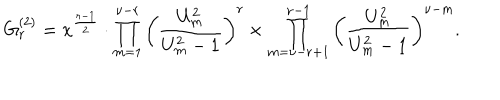

In [ ]:
rand_example_num = int(np.random.rand() * dataset["train"]["N"])
example = get_example(dataset["train"], rand_example_num)
print(rand_example_num, example["tokens"])
print(example["token_nums"])
Image.fromarray(example["img"].numpy(), mode="L")

Create the torch Datasets to be used in the model:

In [ ]:
class HandwrittenDataset(Dataset):
    def __init__(self, dataset_split, processor, n_limit=None, shuffle=False, shuffle_map=None):
        self.dataset_split = dataset_split
        self.processor = processor
        self.n = self.dataset_split["N"] if n_limit is None else n_limit
        self.max_tokens = self.dataset_split["max_tokens"]
        self.shuffle = shuffle

        if shuffle_map is None:
            self.shuffle_map = np.sort(np.random.choice(
                np.arange(self.dataset_split["N"]), size=(self.n,), replace=False))\
                if self.shuffle else None
        else:
            self.n = len(shuffle_map)
            self.shuffle_map = shuffle_map
            self.shuffle = True

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        idx_to_use = self.shuffle_map[idx] if self.shuffle else idx
        example = get_example(self.dataset_split, idx_to_use)
        img = example["img"]
        pixel_values = self.processor(
            img.broadcast_to((3, img.shape[0], img.shape[1])),
            return_tensors="pt").pixel_values
        token_nums = example["token_nums"].clone()
        token_nums[token_nums == word_to_idx["<pad>"]] = -100

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": token_nums
        }

In [ ]:
use_swin = False
if use_swin:
    from transformers import AutoImageProcessor #, SwinModel
    processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224")
else:
    from transformers import TrOCRProcessor
    processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
train_processor, val_processor, test_processor \
    = (HandwrittenDataset(dataset[t], processor) for t in splits)

tiny_train_processor = HandwrittenDataset(dataset["train"], processor, n_limit=50, shuffle=True)
tiny_val_processor = HandwrittenDataset(dataset["val"], processor, n_limit=50, shuffle=True)

Create or load (if already created) a smaller subset of the validation set, since TrOCR models take a really long time to evaluate (e.g. longer than 1 epoch to do the full validation set)

In [ ]:
shuffle_map_fn = "data/smaller_val_shuffle_map.txt"
make_new_shuffle_map = not os.path.exists(shuffle_map_fn)
if not make_new_shuffle_map:
    print("Getting shuffle map from file")
    with open(shuffle_map_fn, "r") as f:
        shuffle_map = np.array([int(i) for i in f.read().split(",")])

    smaller_val_processor = HandwrittenDataset(dataset["val"], processor, shuffle_map=shuffle_map)
else:
    print("Making new shuffle map")
    smaller_val_processor = HandwrittenDataset(dataset["val"], processor, n_limit=1000, shuffle=True)
    with open(shuffle_map_fn, "w+") as sf:
        to_write = ",".join(smaller_val_processor.shuffle_map.astype(str))
        print(to_write)
        print(to_write, end="", file=sf)

print(smaller_val_processor.shuffle_map)

Getting shuffle map from file
[   6   22   28   39   40   41   44   49   57   60   66   94  105  108
  111  112  114  118  119  131  140  157  161  171  177  189  198  202
  206  248  254  270  281  283  288  297  299  311  322  327  338  358
  364  366  367  368  372  373  391  393  404  423  429  441  452  462
  464  468  472  483  490  492  498  503  525  537  542  552  558  563
  571  576  589  591  592  609  614  620  621  625  628  629  655  666
  667  668  677  685  688  694  696  701  707  713  717  731  742  743
  757  758  765  783  797  840  844  866  869  874  878  880  884  888
  910  911  927  928  971  981  996 1004 1005 1006 1041 1060 1064 1075
 1087 1090 1097 1102 1110 1111 1128 1133 1153 1172 1181 1184 1191 1192
 1202 1208 1209 1212 1224 1228 1237 1239 1255 1257 1284 1287 1306 1339
 1344 1347 1349 1359 1361 1363 1372 1377 1390 1422 1425 1431 1455 1461
 1462 1471 1475 1482 1493 1496 1504 1518 1529 1545 1568 1578 1593 1596
 1603 1609 1612 1630 1641 1664 1665 1672 1677 1

Get a random example from the training HandwrittenDataset to verify that tokens and image match:

18786 ['<s>', 'f', '=', '\\psi', '\\left(', '\\theta', '_', '{', '\\tau', '_', '{', '1', '}', '}', ',', '\\theta', '_', '{', '\\tau', '_', '{', '1', '}', '}', '^', '{', '-', '1', '}', '\\theta', '_', '{', '\\tau', '_', '{', '2', '}', '}', ',', '\\cdots', ',', '\\theta', '_', '{', '\\tau', '_', '{', 'n', '-', '1', '}', '}', '^', '{', '-', '1', '}', '\\theta', '_', '{', '\\tau', '_', '{', 'n', '}', '}', '\\right)', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

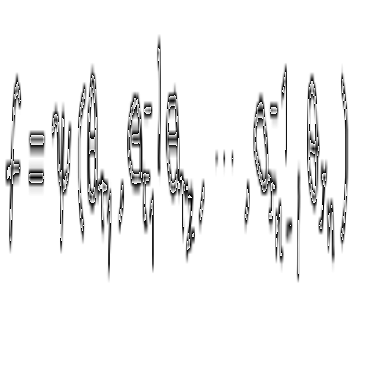

In [ ]:
rand_example_num = np.random.randint(len(train_processor))
example = train_processor[rand_example_num]
labels = example["labels"]
tokens = [idx_to_word[l.item()] for l in labels]
print(rand_example_num, tokens)
print(labels)

pixel_values = example["pixel_values"]
Image.fromarray((pixel_values * 255).movedim(0, 2).numpy().astype(np.uint8))

In [ ]:
tiny_train_loader = DataLoader(tiny_train_processor, batch_size=3, shuffle=True)
tiny_val_loader = DataLoader(tiny_val_processor, batch_size=3, shuffle=True)
tiny_train_loader_bs1 = DataLoader(tiny_train_processor, batch_size=1, shuffle=True)
tiny_val_loader_bs1 = DataLoader(tiny_val_processor, batch_size=1, shuffle=True)

# Transformer Model

Initialize tokenizer to turn predictions into LaTeX tokens:

In [ ]:
# Need to run this
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tokenizers.processors import TemplateProcessing
from tokenizers.pre_tokenizers import WhitespaceSplit
# Create a BPE model

wl_model = models.WordLevel(word_to_idx, unk_token="[UNK]")

tokenizer = Tokenizer(wl_model)
print(tokenizer.get_vocab_size())
tokenizer.pre_tokenizer = WhitespaceSplit()
print(tokenizer.add_special_tokens(['<s>', '<pad>', '</s>', '<unk>', '<mask>']))

tokenizer.post_processor = TemplateProcessing(
    single="<s> $A </s>",
    special_tokens=[
        ("<s>", tokenizer.token_to_id("<s>")),
        ("</s>", tokenizer.token_to_id("</s>"))
    ],
)
print(word_to_idx)
print(labels)
labels[labels == -100] = word_to_idx['<pad>']
dString = tokenizer.decode(list(labels))
print(dString)


422
5
{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, '<mask>': 4, '!': 5, '"': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '--': 15, '---': 16, '.': 17, '/': 18, '0': 19, '1': 20, '2': 21, '3': 22, '4': 23, '5': 24, '6': 25, '7': 26, '8': 27, '9': 28, ':': 29, ';': 30, '<': 31, '=': 32, '>': 33, '?': 34, '@': 35, 'A': 36, 'B': 37, 'C': 38, 'D': 39, 'E': 40, 'F': 41, 'G': 42, 'H': 43, 'I': 44, 'J': 45, 'K': 46, 'L': 47, 'M': 48, 'N': 49, 'O': 50, 'Object]': 51, 'P': 52, 'Q': 53, 'R': 54, 'S': 55, 'T': 56, 'U': 57, 'V': 58, 'W': 59, 'X': 60, 'Y': 61, 'Z': 62, '[': 63, '[object': 64, '\\': 65, '\\!': 66, '\\#': 67, '\\&': 68, '\\,': 69, '\\:': 70, '\\;': 71, '\\Big': 72, '\\Bigg': 73, '\\Biggl': 74, '\\Biggm': 75, '\\Biggr': 76, '\\Bigl': 77, '\\Bigr': 78, '\\Delta': 79, '\\Downarrow': 80, '\\Gamma': 81, '\\Huge': 82, '\\Im': 83, '\\LARGE': 84, '\\Lambda': 85, '\\Large': 86, '\\Leftrightarrow': 87, '\\Longleftarrow': 88, '\\Longleftrightarrow': 89, '\\Longrighta

Initialize WER metrics:

In [ ]:
# Import metrics
import evaluate

metric = evaluate.load("accuracy")
wer_metric = evaluate.load("wer")
special_tokens = ("<s>", "<pad>", "</s>", "<unk>", "<mask>")

def compute_wer(p):
    label_ids = p.label_ids
    pred_ids = p.predictions
    return compute_wer_raw(label_ids, pred_ids)

def compute_wer_raw(label_ids, pred_ids, print_strs=False):
    pred_str = tokenizer.decode_batch(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = word_to_idx['<pad>']
    label_str = tokenizer.decode_batch(label_ids, skip_special_tokens=True)

    if print_strs:
        for ps, ls in zip(pred_str, label_str):
            print("Pred str: ", ps)
            print("label str: ", ls)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer":wer}

def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids

def compute_accuracy_metric(eval_pred):
    logits, labels = eval_pred

    predictions = logits
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
idx_to_word_ignore_special = idx_to_word.copy()
for st in special_tokens:
    idx_to_word_ignore_special[word_to_idx[st]] = ""
idx_to_word_ignore_special[-100] = ""

def ids_to_strs(pred_ids, label_ids, print_strs=False):
    pred_str = [" ".join([idx_to_word_ignore_special.get(p.item(), "<unk>") for p in pi]) for pi in pred_ids]
    label_ids[label_ids == -100] = word_to_idx["<pad>"]
    label_str = [" ".join([idx_to_word_ignore_special[l.item()] for l in li]) for li in label_ids]
    if print_strs:
        for ps, ls in zip(pred_str, label_str):
            print("Pred str: ", ps)
            print("label str: ", ls)

    return pred_str, label_str

def compute_wer_metric(pred_ids, label_ids, print_strs=False):

    pred_str, label_str = ids_to_strs(pred_ids, label_ids, print_strs=print_strs)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
def comp_wer_metric(eval_pred):
  logits, labels = eval_pred
  return compute_wer_metric(logits, labels)

In [ ]:
import gc
model_defined = False
tiny_model_defined = False

In [ ]:
from transformers import VisionEncoderDecoderModel

load_model_from_file = True

Delete models to reload them, if they're defined:

In [ ]:
# # uncomment and run this to refresh
if model_defined:
    model.cpu()
    if tiny_model_defined:
        tiny_trained_model.cpu()
        del tiny_trained_model
    del model, checkpoint
    if use_swin:
        swin_model.cpu()
        decoder.cpu()
        del swin_model, decoder
    gc.collect()
    torch.cuda.empty_cache()

Load a model from the file, if using a saved model. You may want to change `saved_trocr` or `saved_swin`

In [ ]:
if load_model_from_file:
    saved_trocr = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/trocr_model_base_13epoch/checkpoint-25599"
    saved_swin = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/swim_model0"

    model_folder = saved_swin if use_swin else saved_trocr
    print(model_folder)
    model = VisionEncoderDecoderModel.from_pretrained(model_folder)
    if torch.cuda.is_available():
        model.cuda()
    checkpoint = None
    model_defined = True

/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/trocr_model_base_13epoch/checkpoint-25599


In [ ]:
# Set up swin transformer model if using Swin
if use_swin and not load_model_from_file:
    # from transformers import AutoImageProcessor
    from transformers import SwinModel
    swin_checkpoint = "microsoft/swin-small-patch4-window7-224"
    # processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224")
    swin_model = SwinModel.from_pretrained(swin_checkpoint)

In [ ]:
# Load pretrained decoder

if not load_model_from_file:
    if use_swin:
        from transformers import TrOCRForCausalLM
        checkpoint = "microsoft/trocr-base-handwritten"
        #checkpoint = "nlpconnect/vit-gpt2-image-captioning"
        decoder = TrOCRForCausalLM.from_pretrained(checkpoint)
        # decoder = AutoModelForCausalLM.from_pretrained(checkpoint)
        model = VisionEncoderDecoderModel(encoder=swin_model, decoder=decoder)
    else:
        checkpoint = "microsoft/trocr-base-handwritten"
        # checkpoint = "microsoft/trocr-small-handwritten"
        model = VisionEncoderDecoderModel.from_pretrained(checkpoint)
    model_defined = True

    # example code at https://github.com/huggingface/transformers/blob/514de24abfd4416aeba6a6455ad5920f57f3567d/src/transformers/models/trocr/modeling_trocr.py#L729

    # modify vision encoder decoder to change classification
    model.config.decoder_start_token_id = word_to_idx['<s>']
    model.config.pad_token_id = word_to_idx['<pad>']
    model.config.vocab_size = len(word_to_idx)
    model.config.eos_token_id = word_to_idx['</s>']

    model.config.decoder.is_decoder = True
    # model.config.decoder.add_cross_attention = True

    # set beam search parameters
    model.config.max_length = 152
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 4

# Regular Model Training

Define some training arguments and hyperparameters. You may want to change `model_folder` depending on where you want to save your model:

In [ ]:
# Larger train
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from accelerate import notebook_launcher

TRAIN_EPOCHS = 2
LEARNING_RATE = 1e-7
WEIGHT_DECAY = 1e-4
LARGE_TRAIN_BATCH_SIZE = 8
LARGE_VAL_BATCH_SIZE = 4

# train
model_folder = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/trocr_model_base_15epoch"
training_args = Seq2SeqTrainingArguments(
    output_dir=model_folder,
    fp16=True,
    predict_with_generate=True,
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    save_strategy="epoch",
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    logging_steps=10,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=LARGE_TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=LARGE_VAL_BATCH_SIZE,
    save_steps=8192,
    save_total_limit=1,
)

large_trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_processor,
    eval_dataset=smaller_val_processor,
    compute_metrics=compute_wer,
    data_collator=default_data_collator,
)


Finetune the model:

In [ ]:
def large_training_loop():
  large_trainer.train()
notebook_launcher(large_training_loop)

Launching training on one GPU.


Epoch,Training Loss,Validation Loss,Wer
1,0.958100,0.785895,0.453536
2,0.980200,0.778207,0.454859


Removed shared tensor {'decoder.output_projection.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


In [ ]:
# save model
large_trainer.save_model(model_folder)
large_trainer.save_state()

Evaluate the model on the test set:

In [ ]:
large_trainer.evaluate(test_processor)

{'eval_loss': 0.7965346574783325,
 'eval_wer': 0.45862375048089427,
 'eval_runtime': 5849.2179,
 'eval_samples_per_second': 1.463,
 'eval_steps_per_second': 0.366,
 'epoch': 2.0}

Evaluate the model on a tiny subset of the training set:

In [ ]:
large_trainer.evaluate(tiny_train_processor)

{'eval_loss': 0.7806255221366882,
 'eval_wer': 0.4409842368319877,
 'eval_runtime': 39.0643,
 'eval_samples_per_second': 1.28,
 'eval_steps_per_second': 0.333}

Load a saved model:

In [ ]:
# Load model
model_folder = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/trocr_model_base_15epoch"
model = VisionEncoderDecoderModel.from_pretrained(model_folder)
if torch.cuda.is_available():
    model.cuda()
model_defined = True
checkpoint = None

Generate some LaTeX on some validation examples (~50) using the currently defined model:

In [ ]:
print("Generating LaTeX on tiny val...")

model.eval()
wer_total = 0
for batch in tqdm(tiny_val_loader_bs1):
    # predict using generate
    pixel_values = batch["pixel_values"].to(device)
    outputs = model.generate(pixel_values)

    wer_value = compute_wer_metric(outputs, batch["labels"], print_strs=True)["wer"]
    print(f"wer: {wer_value}")
    wer_total += wer_value

print(f"average wer: {wer_total / len(tiny_val_loader_bs1)}")

Generating LaTeX on tiny val...


  0%|          | 0/50 [00:00<?, ?it/s]

Pred str:    { \cal A } = \langle { \cal D } _ { 1 } P _ { [ 1 } [ D , { \cal V } \rangle + ( D 0 , v ) \, v _ { i } [ { \cal P } _ \bullet ( 0 ) } \ , 
label str:   { { \cal A } } = \langle D 0 | P | D 0 , v \rangle + \langle D 0 , v | P | D 0 \rangle ~ ~ ,                                                                                                                      
wer: 1.1515151515151516
Pred str:    { \cal H } ( \vec { x } , t ) = { \frac { \partial } { \delta } } \frac { \delta ^ { 2 } ( \lambda , t ^ { * } ) = \frac { \theta } { \partial t } + \nabla \phi - \nu ^ { 1 } { W } { \cal D } _ { 0 } ^ { 3 } = - i \vec { t } ( { x , t , t ; t ) , 
label str:   \vec { \pi } ( \vec { x } , \, t ) = { \frac { \delta { \cal L } } { { \delta \dot { \vec { u } } } ( \vec { x } , \, t ) } } = { \frac { \partial \vec { u } } { \partial t } } + \nabla \phi - \nu \nabla ^ { 2 } \vec { u } = - \vec { l } ( \vec { x } , t ) ,                                                              
wer:

# Tiny Model Training

These cells are mainly to check if we can overfit the model to a tiny subset of the training set, to make sure that it's properly learning when we train it on the full training set.

In [ ]:
# from transformers import TrainingArguments, Trainer
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator

from accelerate import notebook_launcher

# instatiate some initial trial variables
TRAIN_EPOCHS = 40
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 0
TRAIN_BATCH_SIZE = 5
VAL_BATCH_SIZE = 1

# train
tiny_model_folder = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/tiny_model"
training_args = Seq2SeqTrainingArguments(
    output_dir=tiny_model_folder,
    fp16=True,
    predict_with_generate=True,
    overwrite_output_dir=True,
    evaluation_strategy = "no",#'epoch',
    num_train_epochs=TRAIN_EPOCHS,
    learning_rate=LEARNING_RATE,
    logging_steps=25,
    weight_decay=WEIGHT_DECAY,
    # auto_find_batch_size=True,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=VAL_BATCH_SIZE,
    save_steps=8192,
    #eval_steps=4096,
    save_total_limit=1,
)

# Create the trainer for our model
# just need to create a subclass to change the loss

tiny_trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tiny_train_processor,
    eval_dataset=tiny_train_processor,
    compute_metrics=compute_wer,
    # preprocess_logits_for_metrics = preprocess_logits_for_metrics,
    data_collator=default_data_collator,
)



In [ ]:
# Train the model
def tiny_training_loop():
  tiny_results = tiny_trainer.train()
  # rest is optional but nice to have
  tiny_trainer.save_model()
  tiny_trainer.save_state()
notebook_launcher(tiny_training_loop)

Load the model from where it was saved, to make sure it was saved properly:

In [ ]:
# Load tiny trained model
tiny_model_folder = "/content/drive/Shareddrives/CSE 493G1 Text to Latex /models/tiny_model"
tiny_trained_model = VisionEncoderDecoderModel.from_pretrained(tiny_model_folder)
if torch.cuda.is_available():
    tiny_trained_model.cuda()
tiny_model_defined = True

In [ ]:
model = tiny_trained_model
model_defined = True

In [ ]:
tiny_trained_model = model

In [ ]:
# examination of training comparison (you can run this cell and also run charles' cell beneath this one for results)
count = 0
for batch in tiny_trainer.get_train_dataloader():
  pixel_values = batch['pixel_values']
  labels = batch['labels']

  generated_ids = tiny_trained_model.generate(pixel_values)
  wer = compute_wer_metric(generated_ids, labels)
  print(wer['wer'])
  if count == 3:
    break
  count += 1

In [ ]:
# Run the model on some images and compare outputs to the labels
def run_model_on_examples(processor, indexes):
    examples = [processor[i] for i in indexes]
    images = torch.cat([e["pixel_values"][None, :, :, :] for e in examples])

    labels = [[idx_to_word[i.item()] for i in e["labels"]] for e in examples]
    outputs = model.generate(images.to(device))
    output_labels = [[idx_to_word[i.item()] for i in line] for line in outputs]

    for i in indexes:
        print(f"for example {i}")
        print(f"predicted: {output_labels[i]}")
        print(f"actual: {labels[i]}")

print("Running model on some training examples")
run_model_on_examples(tiny_train_processor, range(50))
# print("Running model on some val examples")
# run_model_on_examples(tiny_val_processor, range(10))